# PAINS flagging of compounds and Murcko scaffold analysis.
This notebook shows the distirvution of unwanted structures in patent documents. It also shows the distribution of murcko scaffolds in patent documents.

# Import Module

In [1]:
import string
from collections import defaultdict

import pandas as pd
from tqdm import tqdm

from rdkit import Chem, RDLogger
from rdkit.Chem import Descriptors

import matplotlib.pyplot as plt
import seaborn as sns

tqdm.pandas()

In [2]:
RDLogger.DisableLog("rdApp.*")

# Add path constants

In [3]:
DATA_DIR = "../data/raw"
PROCESSED_DIR = "../data/processed"
FIGURE_DIR = "../data/figures"
MAPPINGS_DIR = "../data/mappings"

# Calculate PAINS for compounds

# Get molecular weight for scaffolds

# Load data files

In [4]:
property_df = pd.read_csv(
    f"{MAPPINGS_DIR}/property_data.tsv",
    sep="\t",
    low_memory=False,
    usecols=["SMILES", "mw"],
)

pains_compounds_df = pd.read_parquet(
    f"{PROCESSED_DIR}/pains_data.pq", columns=["SMILES", "pains", "pains_count"]
)

murcko_scaffold_df = pd.read_parquet(
    f"{PROCESSED_DIR}/surechembl_generic_mucko.pq",
    columns=["cleaned_smiles", "scaffold", "year", "scaffold_mw"],
)

In [5]:
surechembl_df = pd.read_parquet(
    f"{DATA_DIR}/surechembl_dump.pq", columns=["SMILES", "Field"]
)

In [6]:
desalted_patent_df = pd.read_parquet(f"{PROCESSED_DIR}/patent_data_desalted.pq")
df = surechembl_df.merge(desalted_patent_df, on="SMILES")
df.drop_duplicates(subset=["SMILES", "Field"], inplace=True)
df.head()

,SMILES,Field,year,cleaned_smiles
0,C[C@H](CS)C(=O)N1CCC[C@H]1C(O)=O,Description,2015,C[C@H](CS)C(=O)N1CCC[C@H]1C(=O)O
26,C[C@H](CS)C(=O)N1CCC[C@H]1C(O)=O,Claims,2015,C[C@H](CS)C(=O)N1CCC[C@H]1C(=O)O
657,C[C@H](CS)C(=O)N1CCC[C@H]1C(O)=O,Image (for patents after 2007),2015,C[C@H](CS)C(=O)N1CCC[C@H]1C(=O)O
1845,C[C@H](CS)C(=O)N1CCC[C@H]1C(O)=O,Abstract,2015,C[C@H](CS)C(=O)N1CCC[C@H]1C(=O)O
4787,C[C@H](CS)C(=O)N1CCC[C@H]1C(O)=O,MOL Attachment (US patents after 2007),2015,C[C@H](CS)C(=O)N1CCC[C@H]1C(=O)O


# PAINS alert analysis

In [7]:
# find percentage of unwanted structures in the dataset
(pains_compounds_df["SMILES"].nunique() / property_df["SMILES"].nunique()) * 100

3.628251581487957

In [8]:
pains_compounds_df["pains"].nunique()

277

In [9]:
pain_descriptors = pains_compounds_df["pains"].value_counts().to_frame()

pain_descriptors["percentage"] = (
    pain_descriptors["count"] / pain_descriptors["count"].sum()
) * 100
pain_descriptors.head(10)

,count,percentage
pains,,
Azo_a(324),71014,18.751007
Anil_di_alk_a(478),53127,14.028005
Indol_3yl_alk(461),32290,8.526065
Catechol_a(92),22452,5.928375
Anil_di_alk_c(246),21662,5.719778
Quinone_a(370),19665,5.192477
Dyes5a(27),15568,4.110678
Mannich_a(296),15154,4.001362
Imine_one_a(321),14885,3.930334


# Data processing for visualization

In [10]:
cummulative_counts = []

for year in tqdm(murcko_scaffold_df["year"].unique()):
    t = murcko_scaffold_df[murcko_scaffold_df["year"] <= year]

    in_year_scaffolds = set(t[t["year"] == year]["scaffold"].unique())
    other_scaffolds = set(t[t["year"] != year]["scaffold"].unique())

    cummulative_counts.append(
        {
            "year": year,
            "total_scaffolds": len(in_year_scaffolds.union(other_scaffolds)),
            "new_scaffolds": len(in_year_scaffolds.difference(other_scaffolds)),
            "known_scaffolds": len(in_year_scaffolds.intersection(other_scaffolds)),
        }
    )

cummulative_counts_df = pd.DataFrame(cummulative_counts)

100%|██████████| 8/8 [03:07<00:00, 23.49s/it]


In [11]:
pain_distribution_df = (
    pains_compounds_df["pains_count"].value_counts().to_frame().reset_index()
)
pain_distribution_df.columns = ["pains", "count"]

In [12]:
mol_wt_all_df = pd.merge(
    property_df, murcko_scaffold_df, left_on="SMILES", right_on="cleaned_smiles"
)
mol_wt_all_df.drop_duplicates(subset=["SMILES"], inplace=True)
mol_wt_df = mol_wt_all_df[["mw", "scaffold_mw"]]

# Vizualization

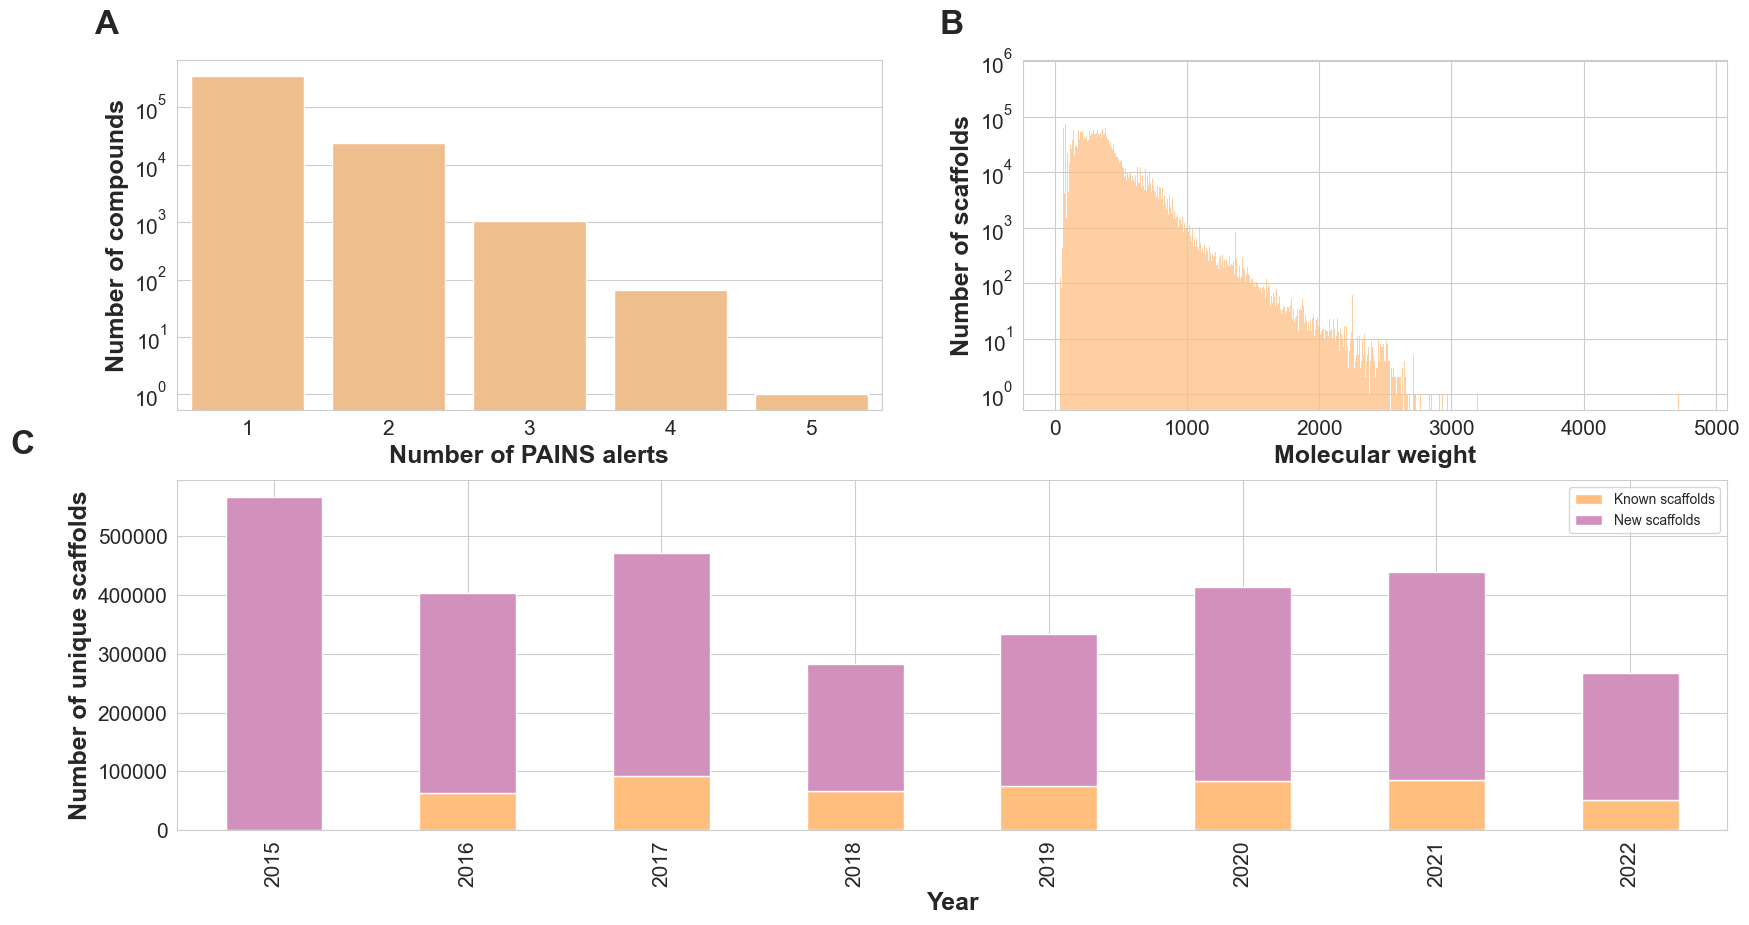

In [13]:
sns.set_style("whitegrid")

fig = plt.figure(figsize=(20, 10))

gs = fig.add_gridspec(2, 2)

# PAINS distribution
ax1 = fig.add_subplot(gs[0, 0])
sns.barplot(
    x=pain_distribution_df["pains"],
    y=pain_distribution_df["count"],
    color="#ffbe7d",
    ax=ax1,
)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.yscale("log")
plt.ylabel("Number of compounds", fontsize=18, fontweight="bold")
plt.xlabel("Number of PAINS alerts", fontsize=18, fontweight="bold")
plt.text(
    -0.1,
    1.1,
    string.ascii_uppercase[0],
    size=24,
    weight="bold",
    horizontalalignment="center",
    verticalalignment="center",
    transform=plt.gca().transAxes,
)

# Scaffold MW distribution
ax2 = fig.add_subplot(gs[0, 1])
sns.histplot(x=mol_wt_df["scaffold_mw"], color="#ffbe7d", ax=ax2)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.yscale("log")
plt.ylabel("Number of scaffolds", fontsize=18, fontweight="bold")
plt.xlabel("Molecular weight", fontsize=18, fontweight="bold")
plt.text(
    -0.1,
    1.1,
    string.ascii_uppercase[1],
    size=24,
    weight="bold",
    horizontalalignment="center",
    verticalalignment="center",
    transform=plt.gca().transAxes,
)

# Scaffold annual count distribution
ax3 = fig.add_subplot(gs[1, :])
cummulative_counts_df.plot(
    x="year",
    y=["known_scaffolds", "new_scaffolds"],
    kind="bar",
    stacked=True,
    color=["#ffbe7d", "#d291bc"],
    label=["Known scaffolds", "New scaffolds"],
    ax=ax3,
)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Year", fontsize=18, fontweight="bold")
plt.ylabel("Number of unique scaffolds", fontsize=18, fontweight="bold")
plt.text(
    -0.1,
    1.1,
    string.ascii_uppercase[2],
    size=24,
    weight="bold",
    horizontalalignment="center",
    verticalalignment="center",
    transform=plt.gca().transAxes,
)

# plt.tight_layout()
plt.savefig(f"{FIGURE_DIR}/figure_5.png", dpi=400)
plt.savefig(f"{FIGURE_DIR}/figure_5.pdf", dpi=400)
plt.show()

# Scaffold and patent sections

In [14]:
# Total and average number of scaffolds
cummulative_counts_df["total_scaffolds"].sum(), cummulative_counts_df[
    "total_scaffolds"
].mean()

(13236105, 1654513.125)

In [15]:
# Total and average number of new scaffolds
cummulative_counts_df["new_scaffolds"].sum(), cummulative_counts_df[
    "new_scaffolds"
].mean()

(2663540, 332942.5)

In [16]:
# Min and max scaffold MW
test = mol_wt_df[~mol_wt_df["scaffold_mw"].isna()]
test = test[test["scaffold_mw"] > 0]
test["scaffold_mw"].min(), test["scaffold_mw"].max()

(38.015650064, 4841.192197964001)

# Tracking back orgin of scaffolds

In [17]:
df.drop_duplicates(subset=["SMILES", "Field"], inplace=True)
murcko_scaffold_df.drop_duplicates(subset=["cleaned_smiles"], inplace=True)

In [18]:
scaffold_pat_field_df = pd.merge(
    df,
    murcko_scaffold_df,
    on="cleaned_smiles",
    how="left",
    suffixes=("", "_y"),
)

In [19]:
scaffold_pat_field_df.drop_duplicates(subset=["scaffold", "Field"], inplace=True)

In [20]:
# Overall distribution of scaffolds
scaffold_pat_field_df = (
    scaffold_pat_field_df.groupby(["Field"])["scaffold"].count().reset_index()
)
scaffold_pat_field_df["%"] = (
    scaffold_pat_field_df["scaffold"] / scaffold_pat_field_df["scaffold"].sum()
) * 100
scaffold_pat_field_df

,Field,scaffold,%
0,Abstract,8120,0.199107
1,Claims,315413,7.734125
2,Description,811216,19.891526
3,Image (for patents after 2007),2261009,55.441360
4,MOL Attachment (US patents after 2007),677947,16.623686
5,Title,4494,0.110196
